In [1]:
!pip install colorama
!pip install gmaps
!pip install optuna

In [2]:
import os
import gc
import cv2
import sys
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import gmaps
import optuna

from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import (StandardScaler,PowerTransformer,
                                   QuantileTransformer,LabelEncoder, 
                                   OneHotEncoder,RobustScaler)

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/AcresBurned/FinalCleanedDataset.csv')

In [4]:
train_data.head()

,AcresBurned,Counties,Latitude,Longitude,Started,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,previous_year,gee_images,path,covertype
0,300.0,Sutter,39.18832,-121.78003,2016-09-20T09:30:00Z,24.1,24.1,32.5,6.7,0.0,19.8,142.0,1011.8,2015-09-20T09:30:00Z,gee_image0,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,PermanentCrop
1,117.0,Calaveras,38.29113,-120.62177,2017-07-17T12:55:00Z,20.1,20.1,42.7,7.0,0.0,2.5,76.0,1008.1,2016-07-17T12:55:00Z,gee_image1,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,Forest
2,320.0,Madera,37.31191,-119.60412,2014-09-14T13:36:00Z,19.1,19.1,54.0,9.6,0.0,7.7,298.0,1007.7,2013-09-14T13:36:00Z,gee_image2,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,Forest
3,104.0,Butte,39.87070,-121.89380,2015-10-02T14:38:00Z,12.2,12.2,91.9,10.9,0.0,1.3,354.0,1017.9,2014-10-02T14:38:00Z,gee_image3,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,PermanentCrop
4,1314.0,San Benito,36.40755,-120.99322,2018-06-04T17:01:00Z,19.7,19.7,58.1,11.3,0.0,16.1,316.0,1014.9,2017-06-04T17:01:00Z,gee_image4,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,PermanentCrop


In [5]:
seed = 1000
nfolds = 5

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed)

In [6]:
train_data.head()

,AcresBurned,Counties,Latitude,Longitude,Started,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,previous_year,gee_images,path,covertype
0,300.0,Sutter,39.18832,-121.78003,2016-09-20T09:30:00Z,24.1,24.1,32.5,6.7,0.0,19.8,142.0,1011.8,2015-09-20T09:30:00Z,gee_image0,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,PermanentCrop
1,117.0,Calaveras,38.29113,-120.62177,2017-07-17T12:55:00Z,20.1,20.1,42.7,7.0,0.0,2.5,76.0,1008.1,2016-07-17T12:55:00Z,gee_image1,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,Forest
2,320.0,Madera,37.31191,-119.60412,2014-09-14T13:36:00Z,19.1,19.1,54.0,9.6,0.0,7.7,298.0,1007.7,2013-09-14T13:36:00Z,gee_image2,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,Forest
3,104.0,Butte,39.87070,-121.89380,2015-10-02T14:38:00Z,12.2,12.2,91.9,10.9,0.0,1.3,354.0,1017.9,2014-10-02T14:38:00Z,gee_image3,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,PermanentCrop
4,1314.0,San Benito,36.40755,-120.99322,2018-06-04T17:01:00Z,19.7,19.7,58.1,11.3,0.0,16.1,316.0,1014.9,2017-06-04T17:01:00Z,gee_image4,/content/drive/MyDrive/AcresBurned/jpeg/gee_im...,PermanentCrop


## EDA

In [7]:
plt.style.use('fivethirtyeight')
def distribution1(feature,color1,color2,df=train_data):
    plt.figure(figsize=(15,7))
    
    plt.subplot(121)
    dist = sns.distplot(df[feature],color=color1)
    a = dist.patches
    xy = [(a[i].get_x() + a[i].get_width() / 2,a[i].get_height()) \
          for i in range(1,len(a)-1) if (a[i].get_height() > a[i-1].get_height() and a[i].get_height() > a[i+1].get_height())]
    
    for i,j in xy:
        dist.annotate(
            s=f"{i:.3f}",
            xy=(i,j), 
            xycoords='data',
            ha='center', 
            va='center', 
            fontsize=11, 
            color='black',
            xytext=(0,7), 
            textcoords='offset points',
        )
    
    qnt = df[feature].quantile([.25, .5, .75]).reset_index(level=0).to_numpy()
    plt.subplot(122)
    box = sns.boxplot(df[feature],color=color2)
    for i,j in qnt:
        box.annotate(str(j)[:4],xy= (j-.05,-0.01),horizontalalignment='center')
        
    print("{}Max value of {} is: {} {:.2f} \n{}Min value of {} is: {} {:.2f}\n{}Mean of {} is: {}{:.2f}\n{}Standard Deviation of {} is:{}{:.2f}"\
      .format(y_,feature,r_,df[feature].max(),g_,feature,r_,df[feature].min(),b_,feature,r_,df[feature].mean(),m_,feature,r_,df[feature].std()))
    
def distribution2(feature,category,df=train_data):
    plt.subplots(figsize=(15, 7))
    sns.histplot(train_data,x=feature,hue=category)

def lineplot1(x,y,color='red',df=train_data):
  plt.figure(figsize=(15,7))
  sns.lineplot(data=df,x=x,y=y,color=color)
  plt.title(f"{x} vs {y}")
  plt.show()


def dist_plot2(label,df=train_data):
    unique = df[label].unique()
    plt.figure(figsize=(15,7))
    for u in unique:
        sns.distplot(x=df[df[label] == u]["AcresBurned"],label=u)
    plt.legend()
    plt.title(f"distplot of Acres Burned based on {label}")


Max value of AcresBurned is:  410203.00 
Min value of AcresBurned is:  0.00
Mean of AcresBurned is: 4779.56
Standard Deviation of AcresBurned is:28734.71


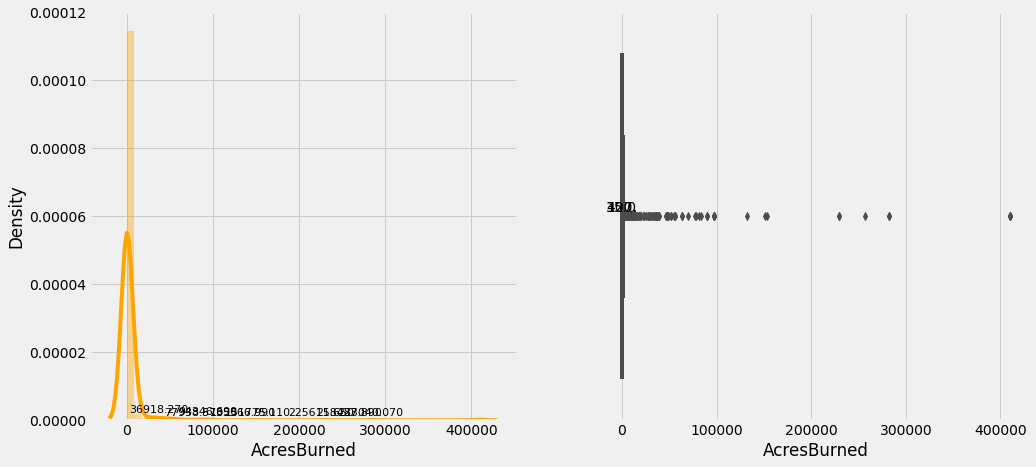

In [8]:
distribution1('AcresBurned','orange','blue')

Max value of temp is:  39.60 
Min value of temp is:  -6.40
Mean of temp is: 19.02
Standard Deviation of temp is:6.93


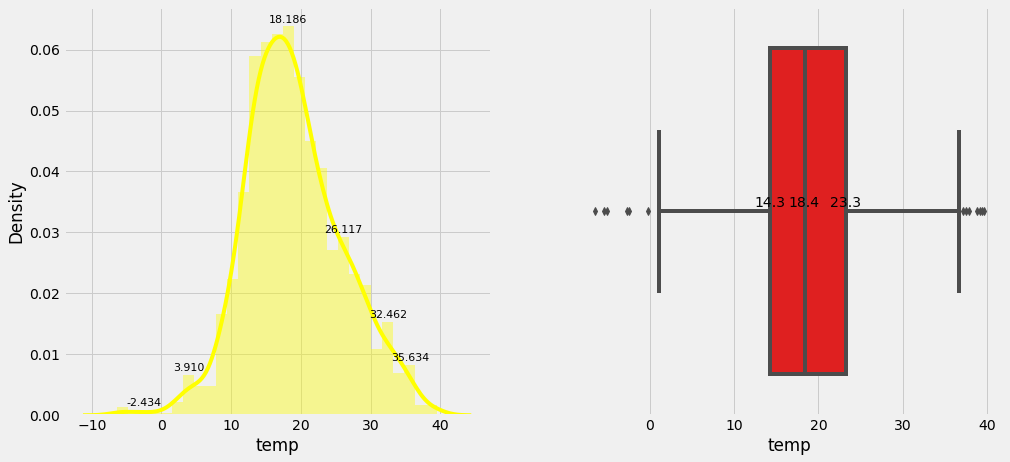

In [9]:
distribution1('temp','yellow','red')

Max value of humidity is:  100.00 
Min value of humidity is:  2.20
Mean of humidity is: 54.39
Standard Deviation of humidity is:23.46


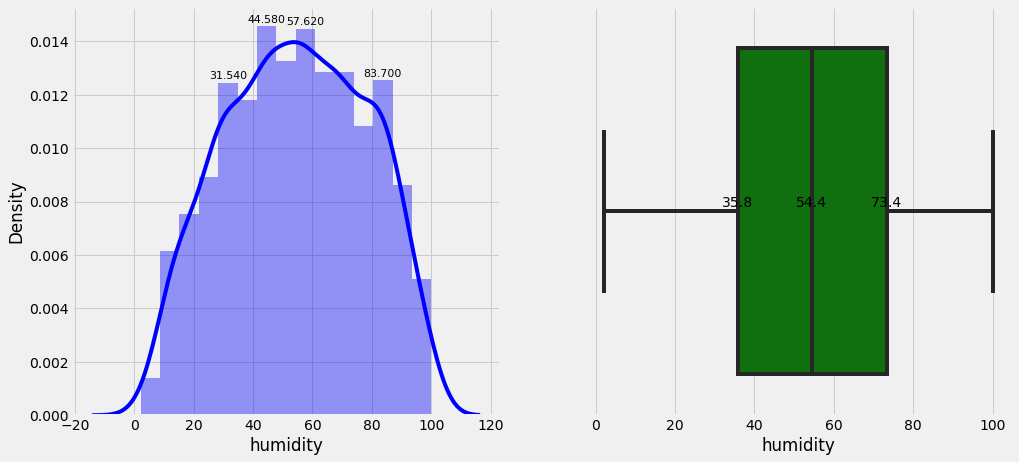

In [10]:
distribution1('humidity','blue','green')

Max value of dew is:  19.70 
Min value of dew is:  -24.30
Mean of dew is: 7.76
Standard Deviation of dew is:6.43


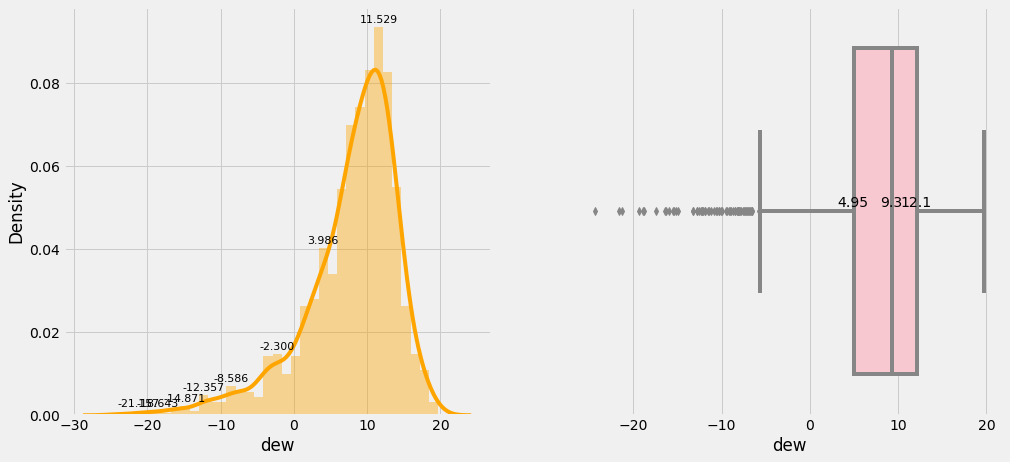

In [11]:
distribution1('dew','orange','pink')

Max value of windspeed is:  53.40 
Min value of windspeed is:  0.00
Mean of windspeed is: 7.93
Standard Deviation of windspeed is:7.49


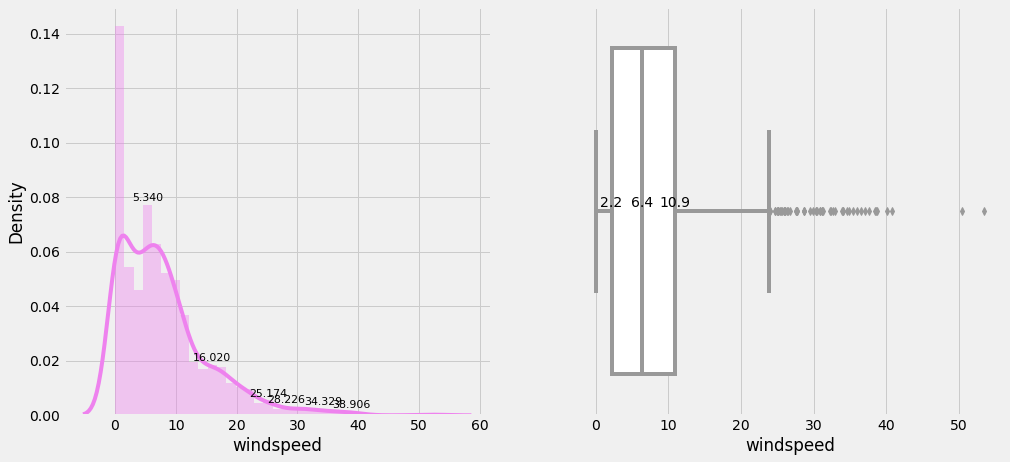

In [12]:
distribution1('windspeed','violet','white')

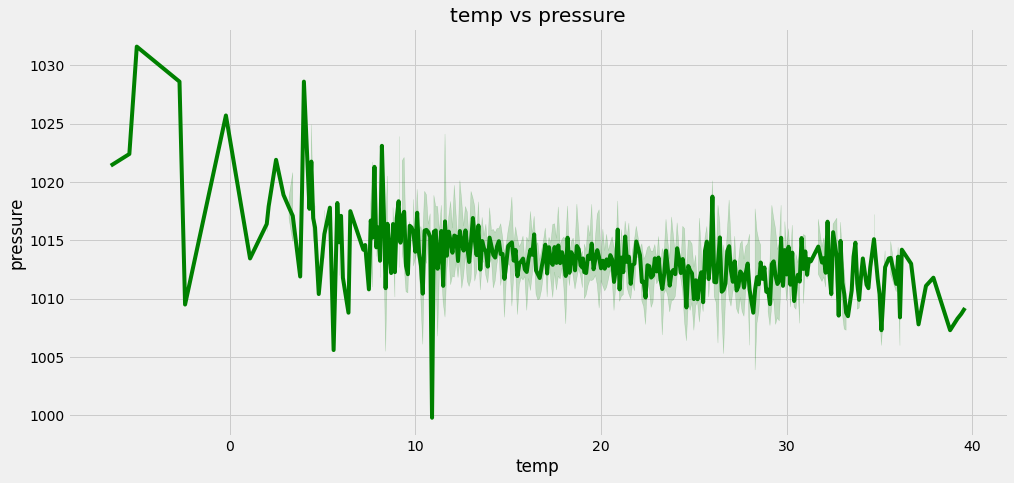

In [13]:
lineplot1('temp','pressure','green')

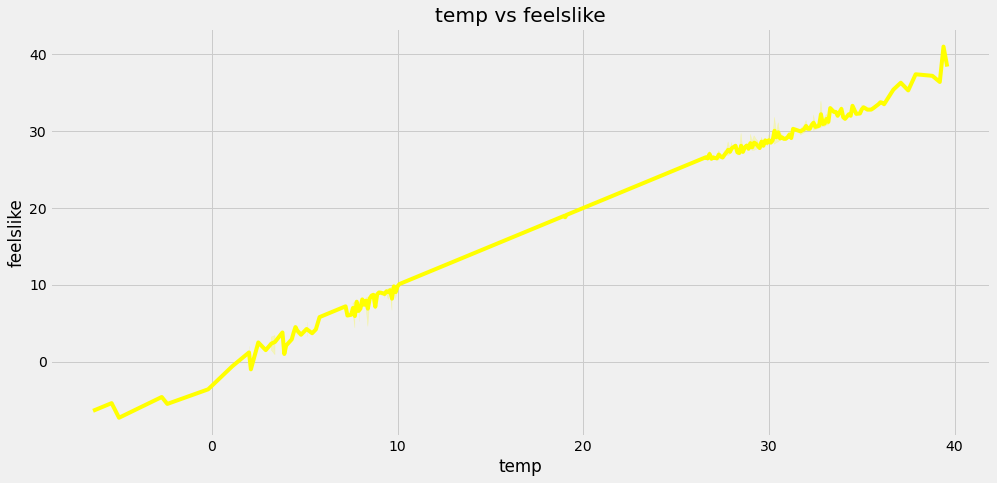

In [14]:
lineplot1('temp','feelslike','yellow')

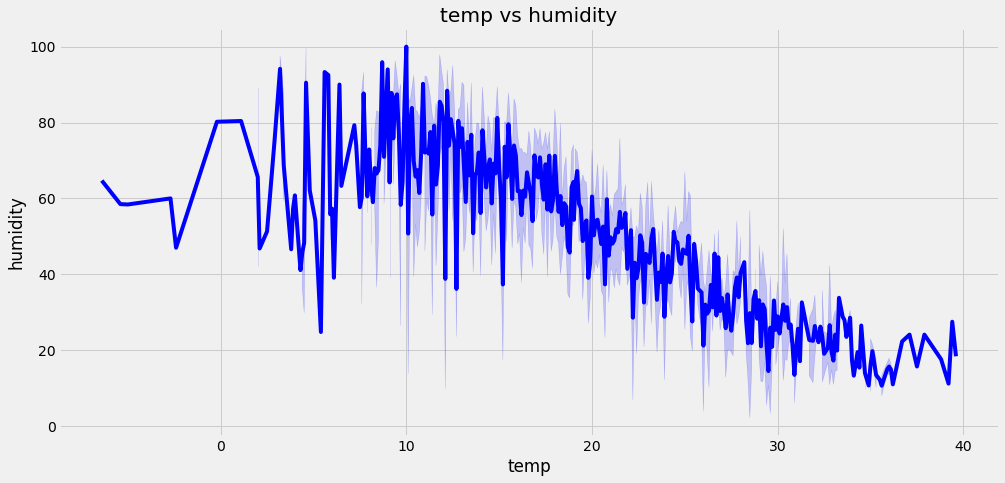

In [15]:
lineplot1('temp','humidity','blue')

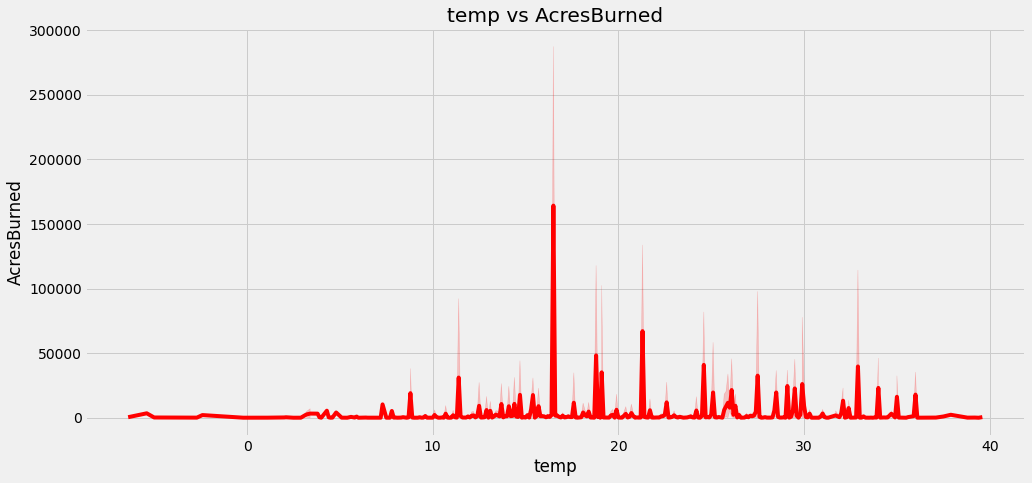

In [16]:
lineplot1('temp','AcresBurned','red')

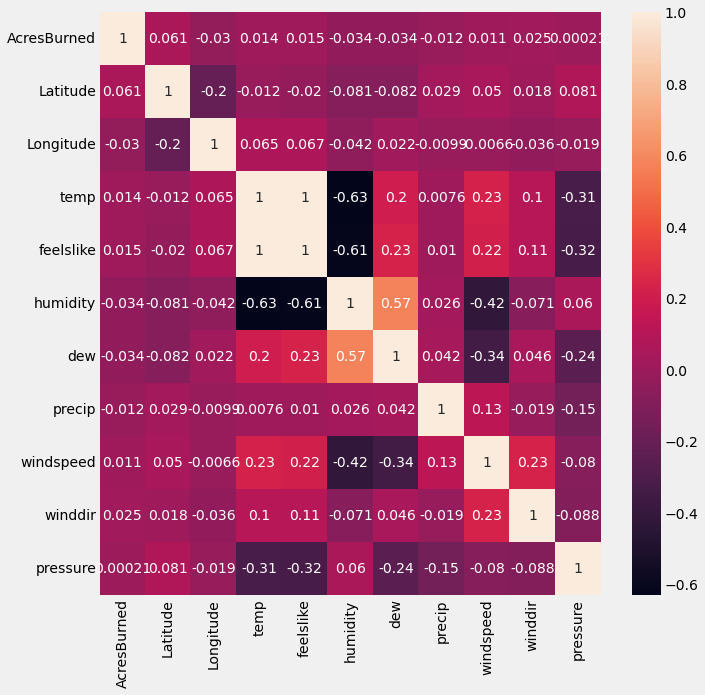

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),annot=True);

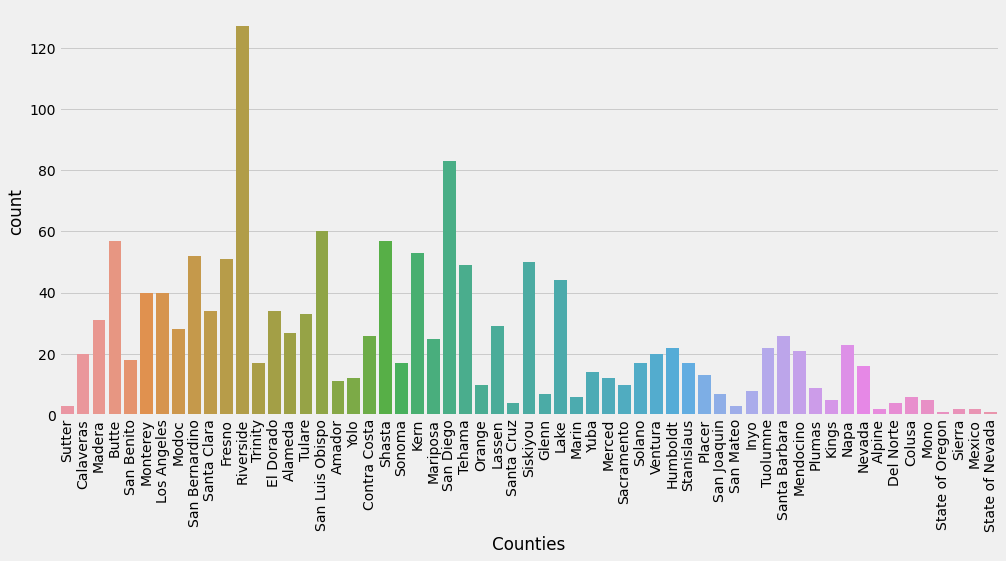

In [18]:
plt.figure(figsize=(15,7))
sns.countplot(train_data.Counties)
plt.xticks(rotation=90);

## Some Plots Based On Covertype

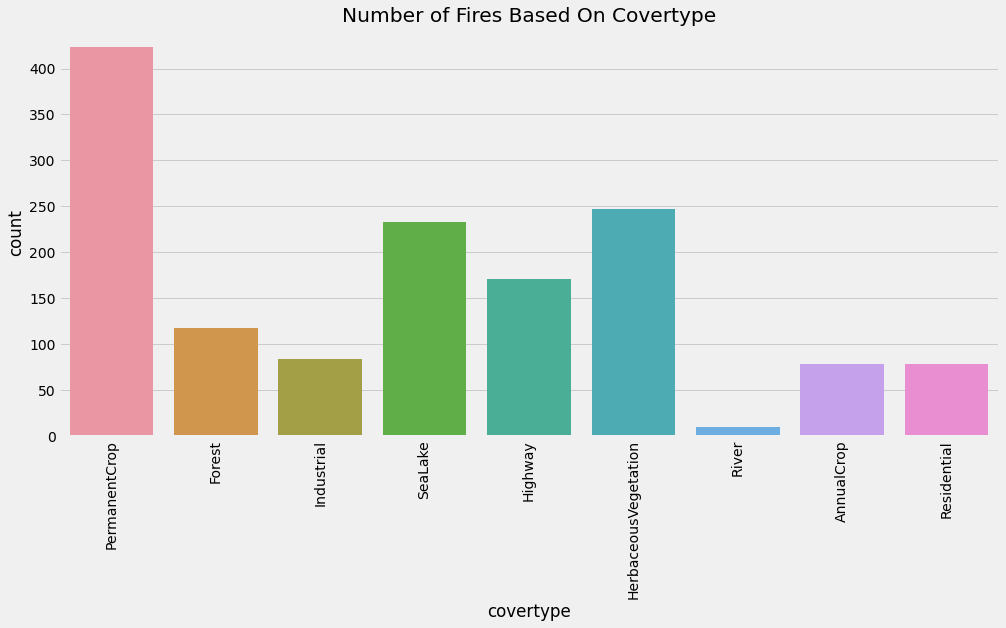

In [19]:
plt.figure(figsize=(15,7))
sns.countplot(train_data['covertype'])
plt.title("Number of Fires Based On Covertype")
plt.xticks(rotation=90);

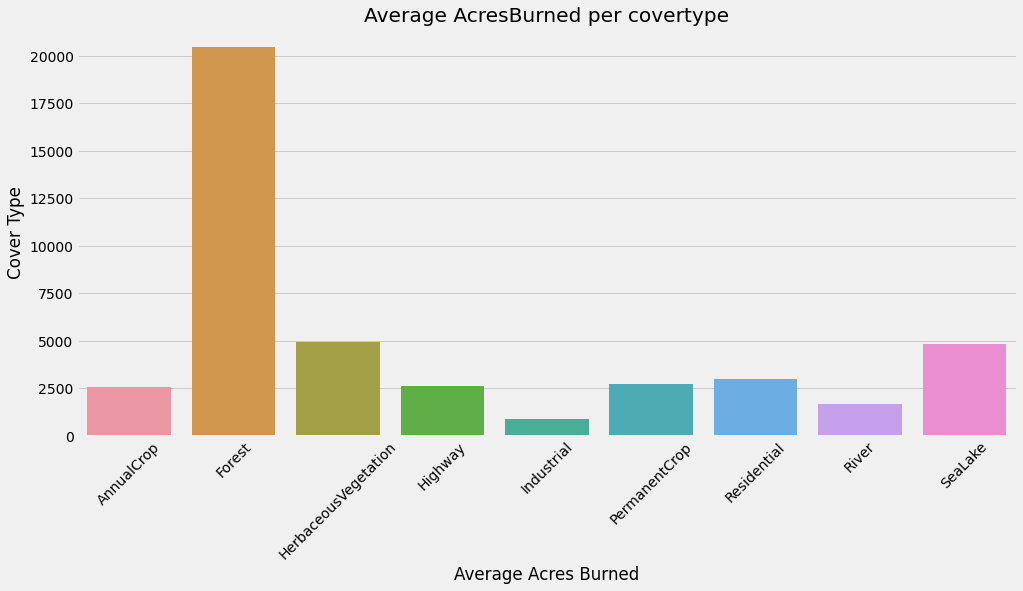

In [20]:
df = train_data.groupby('covertype')['AcresBurned'].mean()
plt.figure(figsize=(15,7))
sns.barplot(x=df.index,y=df.values)
plt.xlabel("Average Acres Burned")
plt.ylabel("Cover Type")
plt.xticks(rotation=45)
plt.title("Average AcresBurned per covertype");

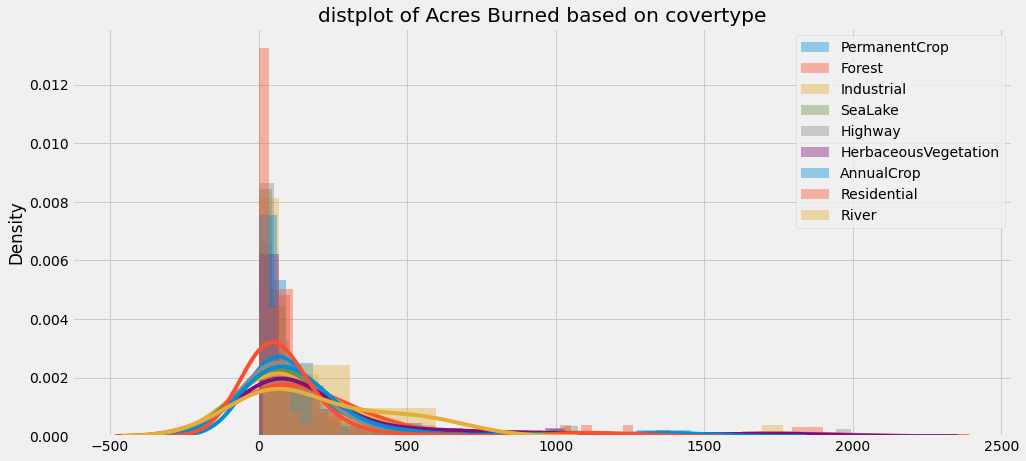

In [21]:
dist_plot2('covertype',df=train_data.query('AcresBurned < 2000'))

## Heatmap on a Map

In [22]:
from google.colab import output
output.enable_custom_widget_manager()
gmaps.configure()
m = gmaps.Map()
data = list(zip(train_data.Latitude.tolist(),train_data.Longitude.tolist()))

In [23]:
m.add_layer(gmaps.Heatmap(data=data,locations=data))
m

Map(configuration={'api_key': None}, data_bounds=[(32.04559363600851, -131.26318717688196), (42.46993673128173…

##Baseline Model

In [24]:
train_data['Fold'] = -1
num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data['bins'] = pd.cut(train_data['AcresBurned'],bins=num_bins,labels=False)

#creating folds
train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=seed)
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=train_data['bins'])):
    train_data.loc[valid_idx,'Fold'] = k

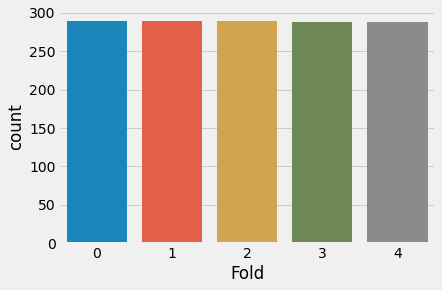

In [25]:
sns.countplot(train_data['Fold']);

In [26]:
target = 'AcresBurned'
cat_feature = ['Counties','covertype']
features= ['Counties','temp','feelslike','humidity','dew','precip','windspeed','winddir','pressure','covertype']

y = train_data[target]
X = train_data[features]
folds = train_data['Fold'].to_numpy()

for c in cat_feature:
  le = LabelEncoder()
  X[c] = le.fit_transform(X[c])

normalize = StandardScaler()
X = normalize.fit_transform(X)

In [27]:
params = {
 'objective':'regression',
 'random_state': seed,
 'boosting_type': 'rf',
 'early_stopping_rounds':800,
  'bagging_fraction': 0.5,
  'bagging_freq': 2,
 'verbose':-1,
 'n_estimators': 10000}

def rmse_score(yreal, yhat):
    return np.sqrt(mean_squared_error(yreal, yhat))

def plot_feature_importance(model):
    feature_importance = pd.DataFrame({"feature":features,"importance":model.feature_importance(importance_type='gain')})
    feature_importance = feature_importance.sort_values(by='importance',ascending=False)
    
    plt.figure(figsize=(5,5))
    sns.barplot(data=feature_importance,x='importance',y='feature')
    plt.title("Importance type Gain")
    
    for idx, v in enumerate(feature_importance.importance):
            plt.text(v, idx, "  {:.2e}".format(v))

In [28]:
def run_lgbm(fold,params):
    print(f"Fold: {fold}")
    x_train,y_train = X[folds != fold], y[folds != fold]
    x_valid,y_valid = X[folds == fold], y[folds == fold]

    lgb_train = lgb.Dataset(x_train,y_train)
    lgb_valid = lgb.Dataset(x_valid,y_valid,reference=lgb_train)
    lgb_model = lgb.train(params,
                      lgb_train, 
                      valid_sets=[lgb_train,lgb_valid],
                      verbose_eval=1000,
                      )
    y_preds = lgb_model.predict(x_valid)
    score = rmse_score(y_valid,y_preds)
    return score,lgb_model

In [29]:
def run_lgbm_nfolds(nfolds,params):
  rmse_scores = list()
  lgb_models = list()

  for fold in range(nfolds):
    score,model = run_lgbm(fold,params)
    rmse_scores.append(score)
    lgb_models.append(model)

  print(rmse_scores)
  print("Average rmse score",np.mean(rmse_scores))

  return rmse_scores,lgb_models

In [30]:
rmse_scores,lgb_models = run_lgbm_nfolds(nfolds,params)

Fold: 0
Training until validation scores don't improve for 800 rounds.
Early stopping, best iteration is:
[20]	training's l2: 7.54722e+08	valid_1's l2: 8.23782e+08
Fold: 1
Training until validation scores don't improve for 800 rounds.
Early stopping, best iteration is:
[24]	training's l2: 7.42758e+08	valid_1's l2: 8.67167e+08
Fold: 2
Training until validation scores don't improve for 800 rounds.
Early stopping, best iteration is:
[12]	training's l2: 7.10069e+08	valid_1's l2: 9.52078e+08
Fold: 3
Training until validation scores don't improve for 800 rounds.
Early stopping, best iteration is:
[6]	training's l2: 8.29555e+08	valid_1's l2: 4.52991e+08
Fold: 4
Training until validation scores don't improve for 800 rounds.
[1000]	training's l2: 7.4786e+08	valid_1's l2: 8.60731e+08
Early stopping, best iteration is:
[794]	training's l2: 7.47532e+08	valid_1's l2: 8.61218e+08
[28701.604297557544, 29447.699704537863, 30855.76429975794, 21283.58357498915, 29346.521016257768]
Average rmse score 279

In [31]:
print("initial rmse score is:" ,np.mean(rmse_scores))

initial rmse score is: 27927.03457862005


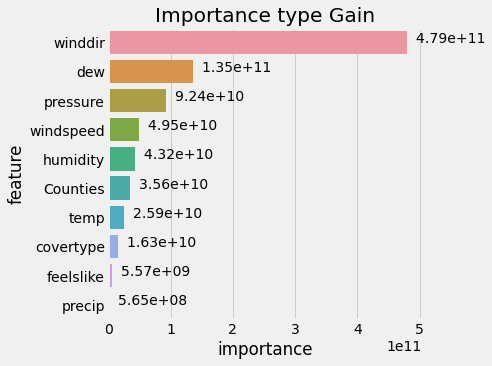

In [32]:
plot_feature_importance(lgb_models[0])

# Optimizing model

In [33]:
x_train,y_train = X[folds != 0], y[folds != 0]
x_valid,y_valid = X[folds == 0], y[folds == 0]

lgb_train = lgb.Dataset(x_train,y_train)
lgb_valid = lgb.Dataset(x_valid,y_valid,reference=lgb_train)

optuna_scores = list()

In [34]:
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 500, 1000),
            'max_bin': trial.suggest_int('max_bin', 100, 900),
            
            'learning_rate': trial.suggest_float('learning_rate',1e-3,5e-1),
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),

            'boosting_type': 'gbdt',
            'random_state' : seed,
            'objective': 'regression',
            'metric': 'RMSE',
            'early_stopping_rounds': 100,
            'num_boost_round':10000,
            }
    
    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=-1)
    y_pred  = model.predict(x_valid)
    score = rmse_score(y_valid, y_pred)
    print(f"RMSE = {score}")
    optuna_scores.append(score)
    return score

In [35]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective,n_trials = 100)

[I 2021-10-26 05:56:08,666] A new study created in memory with name: no-name-dfc7203a-0f9c-4497-8d76-6db04940ac24


Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:08,967] Trial 0 finished with value: 19249.48534758852 and parameters: {'num_leaves': 698, 'max_bin': 349, 'learning_rate': 0.41906412230756307, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.5809738145439726, 'bagging_fraction': 0.4317643230180571, 'bagging_freq': 1, 'min_child_samples': 16, 'lambda_l1': 6.465104683491688e-07, 'lambda_l2': 0.0007501280702072973}. Best is trial 0 with value: 19249.48534758852.


Early stopping, best iteration is:
[100]	valid_0's rmse: 19249.5
RMSE = 19249.48534758852
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:09,359] Trial 1 finished with value: 17888.558997171265 and parameters: {'num_leaves': 824, 'max_bin': 744, 'learning_rate': 0.3800916048607692, 'max_depth': 12, 'min_child_weight': 2, 'feature_fraction': 0.7235136829545095, 'bagging_fraction': 0.5352709938220177, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 4.963967651864813e-07, 'lambda_l2': 0.5268688284140705}. Best is trial 1 with value: 17888.558997171265.


Early stopping, best iteration is:
[100]	valid_0's rmse: 17888.6
RMSE = 17888.558997171265
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:09,719] Trial 2 finished with value: 20108.491027547563 and parameters: {'num_leaves': 705, 'max_bin': 433, 'learning_rate': 0.3303686892662236, 'max_depth': 15, 'min_child_weight': 3, 'feature_fraction': 0.6410758430015049, 'bagging_fraction': 0.5077230671667192, 'bagging_freq': 4, 'min_child_samples': 55, 'lambda_l1': 4.0771893767418175e-08, 'lambda_l2': 1.657208479866353e-08}. Best is trial 1 with value: 17888.558997171265.


Early stopping, best iteration is:
[304]	valid_0's rmse: 20108.5
RMSE = 20108.491027547563
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:10,011] Trial 3 finished with value: 20957.265426391285 and parameters: {'num_leaves': 589, 'max_bin': 384, 'learning_rate': 0.4299860378889335, 'max_depth': 13, 'min_child_weight': 7, 'feature_fraction': 0.5365423219673567, 'bagging_fraction': 0.45162599953944893, 'bagging_freq': 7, 'min_child_samples': 28, 'lambda_l1': 1.4598319367914127e-05, 'lambda_l2': 9.655711803160053e-07}. Best is trial 1 with value: 17888.558997171265.


Early stopping, best iteration is:
[160]	valid_0's rmse: 20957.3
RMSE = 20957.265426391285
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2009]	valid_0's rmse: 18175.4


[I 2021-10-26 05:56:12,517] Trial 4 finished with value: 18175.358292241606 and parameters: {'num_leaves': 695, 'max_bin': 870, 'learning_rate': 0.044570114862604905, 'max_depth': 10, 'min_child_weight': 2, 'feature_fraction': 0.8489616710191994, 'bagging_fraction': 0.8260726789903228, 'bagging_freq': 1, 'min_child_samples': 58, 'lambda_l1': 0.0009506621384110955, 'lambda_l2': 0.00032125785963077035}. Best is trial 1 with value: 17888.558997171265.


RMSE = 18175.358292241606
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:12,953] Trial 5 finished with value: 20464.911440858865 and parameters: {'num_leaves': 549, 'max_bin': 283, 'learning_rate': 0.2520040562427274, 'max_depth': 7, 'min_child_weight': 10, 'feature_fraction': 0.9821634457714031, 'bagging_fraction': 0.4226455267167477, 'bagging_freq': 2, 'min_child_samples': 72, 'lambda_l1': 6.781731807784805e-08, 'lambda_l2': 0.00082421268862406}. Best is trial 1 with value: 17888.558997171265.


Early stopping, best iteration is:
[438]	valid_0's rmse: 20464.9
RMSE = 20464.911440858865
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:13,359] Trial 6 finished with value: 18282.56643173989 and parameters: {'num_leaves': 790, 'max_bin': 282, 'learning_rate': 0.34101074739311726, 'max_depth': 16, 'min_child_weight': 15, 'feature_fraction': 0.781881232547032, 'bagging_fraction': 0.6061953018987845, 'bagging_freq': 6, 'min_child_samples': 24, 'lambda_l1': 2.1690376276947353e-08, 'lambda_l2': 2.7401564024351773e-08}. Best is trial 1 with value: 17888.558997171265.


Early stopping, best iteration is:
[173]	valid_0's rmse: 18282.6
RMSE = 18282.56643173989
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:14,004] Trial 7 finished with value: 16271.578662924729 and parameters: {'num_leaves': 898, 'max_bin': 677, 'learning_rate': 0.24068813457334223, 'max_depth': 6, 'min_child_weight': 11, 'feature_fraction': 0.6302738585570427, 'bagging_fraction': 0.9161267844642423, 'bagging_freq': 6, 'min_child_samples': 28, 'lambda_l1': 6.994927695045795e-05, 'lambda_l2': 0.00021906481270644174}. Best is trial 7 with value: 16271.578662924729.


Early stopping, best iteration is:
[466]	valid_0's rmse: 16271.6
RMSE = 16271.578662924729
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1315]	valid_0's rmse: 15287.7


[I 2021-10-26 05:56:16,498] Trial 8 finished with value: 15287.731322122318 and parameters: {'num_leaves': 906, 'max_bin': 508, 'learning_rate': 0.049906214297807214, 'max_depth': 11, 'min_child_weight': 10, 'feature_fraction': 0.5723034468435726, 'bagging_fraction': 0.9101710870751994, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 2.590373408644475e-07, 'lambda_l2': 1.0357696725076673e-07}. Best is trial 8 with value: 15287.731322122318.


RMSE = 15287.731322122318
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:17,126] Trial 9 finished with value: 17617.77704698112 and parameters: {'num_leaves': 768, 'max_bin': 212, 'learning_rate': 0.22437683452100843, 'max_depth': 7, 'min_child_weight': 2, 'feature_fraction': 0.7387983693348295, 'bagging_fraction': 0.5154526768760704, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 2.484953957713547e-06, 'lambda_l2': 9.528269690074246e-05}. Best is trial 8 with value: 15287.731322122318.


Early stopping, best iteration is:
[380]	valid_0's rmse: 17617.8
RMSE = 17617.77704698112
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[10000]	valid_0's rmse: 18253.8


[I 2021-10-26 05:56:28,494] Trial 10 finished with value: 18253.834749846545 and parameters: {'num_leaves': 993, 'max_bin': 572, 'learning_rate': 0.004057935047986294, 'max_depth': 12, 'min_child_weight': 16, 'feature_fraction': 0.42498634649089645, 'bagging_fraction': 0.7513478055913541, 'bagging_freq': 8, 'min_child_samples': 40, 'lambda_l1': 0.7673292546951654, 'lambda_l2': 1.1160450860933022e-06}. Best is trial 8 with value: 15287.731322122318.


RMSE = 18253.834749846545
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:29,185] Trial 11 finished with value: 17765.49031247869 and parameters: {'num_leaves': 950, 'max_bin': 597, 'learning_rate': 0.1291821968082149, 'max_depth': 4, 'min_child_weight': 12, 'feature_fraction': 0.47941060303615746, 'bagging_fraction': 0.9664973555577409, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.0006270508230176696, 'lambda_l2': 0.05577547047218211}. Best is trial 8 with value: 15287.731322122318.


Early stopping, best iteration is:
[678]	valid_0's rmse: 17765.5
RMSE = 17765.49031247869
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:29,888] Trial 12 finished with value: 16307.673518105341 and parameters: {'num_leaves': 887, 'max_bin': 695, 'learning_rate': 0.14862194891930952, 'max_depth': 4, 'min_child_weight': 12, 'feature_fraction': 0.6192396808432565, 'bagging_fraction': 0.9745214332073775, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 0.006576790254721518, 'lambda_l2': 8.430539168632776e-06}. Best is trial 8 with value: 15287.731322122318.


Early stopping, best iteration is:
[689]	valid_0's rmse: 16307.7
RMSE = 16307.673518105341
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:30,995] Trial 13 finished with value: 14949.65063754647 and parameters: {'num_leaves': 893, 'max_bin': 530, 'learning_rate': 0.10832944291419924, 'max_depth': 7, 'min_child_weight': 7, 'feature_fraction': 0.5306360974191668, 'bagging_fraction': 0.8661747595514948, 'bagging_freq': 6, 'min_child_samples': 8, 'lambda_l1': 3.811211870880003e-05, 'lambda_l2': 0.012233197061356539}. Best is trial 13 with value: 14949.65063754647.


Early stopping, best iteration is:
[586]	valid_0's rmse: 14949.7
RMSE = 14949.65063754647
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:31,673] Trial 14 finished with value: 16268.874278487569 and parameters: {'num_leaves': 865, 'max_bin': 499, 'learning_rate': 0.11717791874923637, 'max_depth': 9, 'min_child_weight': 7, 'feature_fraction': 0.5044340542911556, 'bagging_fraction': 0.8461283133361615, 'bagging_freq': 5, 'min_child_samples': 4, 'lambda_l1': 1.444480978032077e-05, 'lambda_l2': 0.02946061883578293}. Best is trial 13 with value: 14949.65063754647.


Early stopping, best iteration is:
[228]	valid_0's rmse: 16268.9
RMSE = 16268.874278487569
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:32,342] Trial 15 finished with value: 14692.148772905008 and parameters: {'num_leaves': 956, 'max_bin': 500, 'learning_rate': 0.06679458538389235, 'max_depth': 8, 'min_child_weight': 6, 'feature_fraction': 0.41190547604429667, 'bagging_fraction': 0.6981803947049372, 'bagging_freq': 8, 'min_child_samples': 4, 'lambda_l1': 0.04555729853056256, 'lambda_l2': 0.0046127590908992}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[304]	valid_0's rmse: 14692.1
RMSE = 14692.148772905008
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:32,528] Trial 16 finished with value: 19121.40259525749 and parameters: {'num_leaves': 992, 'max_bin': 160, 'learning_rate': 0.49537994995148266, 'max_depth': 6, 'min_child_weight': 5, 'feature_fraction': 0.4455925318361587, 'bagging_fraction': 0.6812615943329541, 'bagging_freq': 8, 'min_child_samples': 5, 'lambda_l1': 0.09167183925033683, 'lambda_l2': 0.016262179736658017}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[23]	valid_0's rmse: 19121.4
RMSE = 19121.40259525749
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:33,060] Trial 17 finished with value: 17855.35685186998 and parameters: {'num_leaves': 943, 'max_bin': 798, 'learning_rate': 0.18008353103551195, 'max_depth': 8, 'min_child_weight': 6, 'feature_fraction': 0.4020845749093664, 'bagging_fraction': 0.7237481563983594, 'bagging_freq': 7, 'min_child_samples': 51, 'lambda_l1': 0.015913571576294874, 'lambda_l2': 0.005707541395278746}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[434]	valid_0's rmse: 17855.4
RMSE = 17855.35685186998
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:34,267] Trial 18 finished with value: 18126.434454821843 and parameters: {'num_leaves': 829, 'max_bin': 599, 'learning_rate': 0.0837075362167741, 'max_depth': 5, 'min_child_weight': 8, 'feature_fraction': 0.5344322214628296, 'bagging_fraction': 0.6449189314354123, 'bagging_freq': 7, 'min_child_samples': 68, 'lambda_l1': 0.00048240500062185233, 'lambda_l2': 0.7773566086311182}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[1384]	valid_0's rmse: 18126.4
RMSE = 18126.434454821843
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:34,661] Trial 19 finished with value: 16150.265198577174 and parameters: {'num_leaves': 950, 'max_bin': 494, 'learning_rate': 0.18233141448739787, 'max_depth': 8, 'min_child_weight': 5, 'feature_fraction': 0.4661462733713839, 'bagging_fraction': 0.7866994789557911, 'bagging_freq': 8, 'min_child_samples': 21, 'lambda_l1': 0.8796398914937166, 'lambda_l2': 0.00367923061242161}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[216]	valid_0's rmse: 16150.3
RMSE = 16150.265198577174
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4802]	valid_0's rmse: 18715.4


[I 2021-10-26 05:56:38,742] Trial 20 finished with value: 18715.380701011214 and parameters: {'num_leaves': 642, 'max_bin': 442, 'learning_rate': 0.018199145309746444, 'max_depth': 10, 'min_child_weight': 9, 'feature_fraction': 0.6714128217860061, 'bagging_fraction': 0.5961015731841206, 'bagging_freq': 7, 'min_child_samples': 79, 'lambda_l1': 0.0160565893198907, 'lambda_l2': 4.364641440384932e-05}. Best is trial 15 with value: 14692.148772905008.


RMSE = 18715.380701011214
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:39,604] Trial 21 finished with value: 15005.79502157788 and parameters: {'num_leaves': 914, 'max_bin': 555, 'learning_rate': 0.07703644601618691, 'max_depth': 11, 'min_child_weight': 9, 'feature_fraction': 0.5903647229399924, 'bagging_fraction': 0.8865372888504974, 'bagging_freq': 5, 'min_child_samples': 9, 'lambda_l1': 5.41391024113746e-05, 'lambda_l2': 2.0657429178605624e-07}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[280]	valid_0's rmse: 15005.8
RMSE = 15005.79502157788
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:40,564] Trial 22 finished with value: 15747.733490379127 and parameters: {'num_leaves': 847, 'max_bin': 555, 'learning_rate': 0.08036507985487717, 'max_depth': 14, 'min_child_weight': 8, 'feature_fraction': 0.5635413370091692, 'bagging_fraction': 0.8737328633696099, 'bagging_freq': 6, 'min_child_samples': 9, 'lambda_l1': 4.363017704161076e-05, 'lambda_l2': 0.1516766527216433}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[258]	valid_0's rmse: 15747.7
RMSE = 15747.733490379127
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:41,628] Trial 23 finished with value: 15755.127710814628 and parameters: {'num_leaves': 923, 'max_bin': 653, 'learning_rate': 0.08026418633870289, 'max_depth': 10, 'min_child_weight': 6, 'feature_fraction': 0.501108147059591, 'bagging_fraction': 0.8090546145644634, 'bagging_freq': 3, 'min_child_samples': 7, 'lambda_l1': 3.828359473398545e-06, 'lambda_l2': 0.002708152511055816}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[371]	valid_0's rmse: 15755.1
RMSE = 15755.127710814628
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:42,375] Trial 24 finished with value: 15410.210034699609 and parameters: {'num_leaves': 983, 'max_bin': 426, 'learning_rate': 0.15708694018211722, 'max_depth': 8, 'min_child_weight': 14, 'feature_fraction': 0.40563720913582535, 'bagging_fraction': 0.7673296786344812, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.0020358099558764114, 'lambda_l2': 7.64621273226531e-06}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[511]	valid_0's rmse: 15410.2
RMSE = 15410.210034699609
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:43,200] Trial 25 finished with value: 15253.715036786658 and parameters: {'num_leaves': 799, 'max_bin': 634, 'learning_rate': 0.10698058327052612, 'max_depth': 11, 'min_child_weight': 9, 'feature_fraction': 0.5948815847858432, 'bagging_fraction': 0.6945382658099101, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.00022361161258787425, 'lambda_l2': 2.141164421762817e-05}. Best is trial 15 with value: 14692.148772905008.


Early stopping, best iteration is:
[345]	valid_0's rmse: 15253.7
RMSE = 15253.715036786658
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1476]	valid_0's rmse: 17224.5


[I 2021-10-26 05:56:44,834] Trial 26 finished with value: 17224.526168263154 and parameters: {'num_leaves': 871, 'max_bin': 509, 'learning_rate': 0.0459584446661441, 'max_depth': 6, 'min_child_weight': 7, 'feature_fraction': 0.52497694670629, 'bagging_fraction': 0.906481679506931, 'bagging_freq': 6, 'min_child_samples': 37, 'lambda_l1': 0.09321121571090654, 'lambda_l2': 0.10899343011169246}. Best is trial 15 with value: 14692.148772905008.


RMSE = 17224.526168263154
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:45,178] Trial 27 finished with value: 12997.088500850423 and parameters: {'num_leaves': 952, 'max_bin': 366, 'learning_rate': 0.21439500466986972, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.4616489585318717, 'bagging_fraction': 0.9992710829788103, 'bagging_freq': 8, 'min_child_samples': 4, 'lambda_l1': 0.0001259404068828715, 'lambda_l2': 2.4228946143770897e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[51]	valid_0's rmse: 12997.1
RMSE = 12997.088500850423
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:46,017] Trial 28 finished with value: 16022.416712819037 and parameters: {'num_leaves': 976, 'max_bin': 360, 'learning_rate': 0.2755998792609947, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.45907992317707025, 'bagging_fraction': 0.9663506710552384, 'bagging_freq': 8, 'min_child_samples': 16, 'lambda_l1': 0.12342788354075108, 'lambda_l2': 0.0017765829107024883}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[455]	valid_0's rmse: 16022.4
RMSE = 16022.416712819037
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:46,396] Trial 29 finished with value: 14387.17103709878 and parameters: {'num_leaves': 939, 'max_bin': 312, 'learning_rate': 0.18939606338507825, 'max_depth': 7, 'min_child_weight': 1, 'feature_fraction': 0.4574098628156257, 'bagging_fraction': 0.9982634594603628, 'bagging_freq': 7, 'min_child_samples': 4, 'lambda_l1': 2.605720359562919e-06, 'lambda_l2': 0.007144890220425292}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[133]	valid_0's rmse: 14387.2
RMSE = 14387.17103709878
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:46,801] Trial 30 finished with value: 16436.225260596 and parameters: {'num_leaves': 731, 'max_bin': 318, 'learning_rate': 0.30998614903515836, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.4444063495196813, 'bagging_fraction': 0.998902204491503, 'bagging_freq': 8, 'min_child_samples': 34, 'lambda_l1': 2.061936184540193e-06, 'lambda_l2': 0.0005846580742521975}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[211]	valid_0's rmse: 16436.2
RMSE = 16436.225260596
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:47,083] Trial 31 finished with value: 13459.327959751456 and parameters: {'num_leaves': 938, 'max_bin': 243, 'learning_rate': 0.19638682334017812, 'max_depth': 7, 'min_child_weight': 1, 'feature_fraction': 0.48358780367737253, 'bagging_fraction': 0.9310021497922945, 'bagging_freq': 7, 'min_child_samples': 4, 'lambda_l1': 1.014474066390508e-05, 'lambda_l2': 0.014217990230611047}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[67]	valid_0's rmse: 13459.3
RMSE = 13459.327959751456
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:47,755] Trial 32 finished with value: 15915.79812145756 and parameters: {'num_leaves': 943, 'max_bin': 218, 'learning_rate': 0.2154250841710343, 'max_depth': 8, 'min_child_weight': 1, 'feature_fraction': 0.4888960528681, 'bagging_fraction': 0.9507469416590835, 'bagging_freq': 7, 'min_child_samples': 16, 'lambda_l1': 2.148534756302058e-07, 'lambda_l2': 0.23314130061239285}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[397]	valid_0's rmse: 15915.8
RMSE = 15915.79812145756
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:48,132] Trial 33 finished with value: 15710.652485024102 and parameters: {'num_leaves': 963, 'max_bin': 121, 'learning_rate': 0.2785705219409918, 'max_depth': 5, 'min_child_weight': 1, 'feature_fraction': 0.4334056309870537, 'bagging_fraction': 0.9370525011352787, 'bagging_freq': 8, 'min_child_samples': 4, 'lambda_l1': 9.723336520912755e-07, 'lambda_l2': 0.010925553261621064}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[230]	valid_0's rmse: 15710.7
RMSE = 15710.652485024102
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:48,606] Trial 34 finished with value: 16313.748457634056 and parameters: {'num_leaves': 926, 'max_bin': 264, 'learning_rate': 0.19207308765997216, 'max_depth': 7, 'min_child_weight': 3, 'feature_fraction': 0.4660228047846786, 'bagging_fraction': 0.9955903270231938, 'bagging_freq': 7, 'min_child_samples': 13, 'lambda_l1': 8.955110464087723e-06, 'lambda_l2': 0.052102896778795406}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[254]	valid_0's rmse: 16313.7
RMSE = 16313.748457634056
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:49,135] Trial 35 finished with value: 15520.438509781226 and parameters: {'num_leaves': 1000, 'max_bin': 394, 'learning_rate': 0.20799477646955714, 'max_depth': 9, 'min_child_weight': 3, 'feature_fraction': 0.8924814628511415, 'bagging_fraction': 0.9412743025253815, 'bagging_freq': 7, 'min_child_samples': 4, 'lambda_l1': 1.1696021406217945e-05, 'lambda_l2': 0.0008912687458871174}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[82]	valid_0's rmse: 15520.4
RMSE = 15520.438509781226
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:49,772] Trial 36 finished with value: 15445.315307328967 and parameters: {'num_leaves': 510, 'max_bin': 322, 'learning_rate': 0.1515803258142882, 'max_depth': 5, 'min_child_weight': 1, 'feature_fraction': 0.4033843955032335, 'bagging_fraction': 0.6458145992457404, 'bagging_freq': 8, 'min_child_samples': 13, 'lambda_l1': 6.063842862260782e-07, 'lambda_l2': 1.1158485643191361e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[592]	valid_0's rmse: 15445.3
RMSE = 15445.315307328967
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:50,162] Trial 37 finished with value: 19228.631518458173 and parameters: {'num_leaves': 846, 'max_bin': 207, 'learning_rate': 0.27611476019894576, 'max_depth': 7, 'min_child_weight': 2, 'feature_fraction': 0.5578801729828289, 'bagging_fraction': 0.4642092490118579, 'bagging_freq': 7, 'min_child_samples': 47, 'lambda_l1': 0.0001721290149168558, 'lambda_l2': 0.004793527065842215}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[328]	valid_0's rmse: 19228.6
RMSE = 19228.631518458173
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:50,491] Trial 38 finished with value: 17856.628390601734 and parameters: {'num_leaves': 680, 'max_bin': 418, 'learning_rate': 0.3757300002808135, 'max_depth': 6, 'min_child_weight': 4, 'feature_fraction': 0.669561430653586, 'bagging_fraction': 0.5842251389241763, 'bagging_freq': 8, 'min_child_samples': 22, 'lambda_l1': 9.059733590137081e-08, 'lambda_l2': 1.0477359813053194e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[214]	valid_0's rmse: 17856.6
RMSE = 17856.628390601734
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:50,856] Trial 39 finished with value: 17063.282142711643 and parameters: {'num_leaves': 812, 'max_bin': 253, 'learning_rate': 0.2458359202863451, 'max_depth': 8, 'min_child_weight': 3, 'feature_fraction': 0.4962311129869519, 'bagging_fraction': 0.8234592076033657, 'bagging_freq': 7, 'min_child_samples': 28, 'lambda_l1': 0.0026885624100360756, 'lambda_l2': 0.00014120646554155304}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[206]	valid_0's rmse: 17063.3
RMSE = 17063.282142711643
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:51,323] Trial 40 finished with value: 17751.857361457893 and parameters: {'num_leaves': 874, 'max_bin': 332, 'learning_rate': 0.3040245903597575, 'max_depth': 9, 'min_child_weight': 5, 'feature_fraction': 0.937680308825148, 'bagging_fraction': 0.5584819582791165, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 4.685208214004739e-06, 'lambda_l2': 0.0016154280789138834}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[221]	valid_0's rmse: 17751.9
RMSE = 17751.857361457893
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:51,912] Trial 41 finished with value: 16732.925196296514 and parameters: {'num_leaves': 901, 'max_bin': 371, 'learning_rate': 0.16460614572357213, 'max_depth': 7, 'min_child_weight': 6, 'feature_fraction': 0.5262229228491178, 'bagging_fraction': 0.8580053448984593, 'bagging_freq': 6, 'min_child_samples': 8, 'lambda_l1': 4.1318750276385026e-05, 'lambda_l2': 0.015333344661140967}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[294]	valid_0's rmse: 16732.9
RMSE = 16732.925196296514
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:52,306] Trial 42 finished with value: 16289.795086339715 and parameters: {'num_leaves': 930, 'max_bin': 468, 'learning_rate': 0.13402421083030555, 'max_depth': 7, 'min_child_weight': 2, 'feature_fraction': 0.43622255337216004, 'bagging_fraction': 0.9208226576385623, 'bagging_freq': 6, 'min_child_samples': 12, 'lambda_l1': 2.749640900435057e-05, 'lambda_l2': 0.00908520117360828}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[210]	valid_0's rmse: 16289.8
RMSE = 16289.795086339715
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:53,007] Trial 43 finished with value: 15514.330987019734 and parameters: {'num_leaves': 966, 'max_bin': 308, 'learning_rate': 0.10366547131439272, 'max_depth': 6, 'min_child_weight': 1, 'feature_fraction': 0.5215148836430948, 'bagging_fraction': 0.9868924650938506, 'bagging_freq': 7, 'min_child_samples': 8, 'lambda_l1': 0.00019513569228730326, 'lambda_l2': 0.033561807228508725}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[473]	valid_0's rmse: 15514.3
RMSE = 15514.330987019734
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:53,361] Trial 44 finished with value: 16105.436576856331 and parameters: {'num_leaves': 893, 'max_bin': 150, 'learning_rate': 0.22517954294014525, 'max_depth': 8, 'min_child_weight': 7, 'feature_fraction': 0.7671373198604562, 'bagging_fraction': 0.8934651824352147, 'bagging_freq': 8, 'min_child_samples': 10, 'lambda_l1': 1.2985728903550534e-06, 'lambda_l2': 0.0003735009528171248}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[109]	valid_0's rmse: 16105.4
RMSE = 16105.436576856331
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:54,002] Trial 45 finished with value: 15809.745555474537 and parameters: {'num_leaves': 970, 'max_bin': 399, 'learning_rate': 0.19532281744104502, 'max_depth': 7, 'min_child_weight': 5, 'feature_fraction': 0.48208632852456207, 'bagging_fraction': 0.7282062887474196, 'bagging_freq': 6, 'min_child_samples': 15, 'lambda_l1': 5.707809726949507e-06, 'lambda_l2': 0.3472945825392797}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[402]	valid_0's rmse: 15809.7
RMSE = 15809.745555474537
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:54,822] Trial 46 finished with value: 15401.768058265536 and parameters: {'num_leaves': 777, 'max_bin': 721, 'learning_rate': 0.1333165553082712, 'max_depth': 5, 'min_child_weight': 4, 'feature_fraction': 0.550771201017203, 'bagging_fraction': 0.9557006324344718, 'bagging_freq': 7, 'min_child_samples': 25, 'lambda_l1': 1.893153633406617e-08, 'lambda_l2': 6.465777130157695e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[791]	valid_0's rmse: 15401.8
RMSE = 15401.768058265536
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:56,140] Trial 47 finished with value: 17391.99005972901 and parameters: {'num_leaves': 910, 'max_bin': 248, 'learning_rate': 0.02533629732509507, 'max_depth': 10, 'min_child_weight': 2, 'feature_fraction': 0.8135963248679988, 'bagging_fraction': 0.9265012284861328, 'bagging_freq': 8, 'min_child_samples': 6, 'lambda_l1': 0.00010895546453306653, 'lambda_l2': 0.07045617580697233}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[456]	valid_0's rmse: 17392
RMSE = 17391.99005972901
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:57,443] Trial 48 finished with value: 18785.391845832663 and parameters: {'num_leaves': 853, 'max_bin': 472, 'learning_rate': 0.06271732366838079, 'max_depth': 8, 'min_child_weight': 3, 'feature_fraction': 0.4244845303307531, 'bagging_fraction': 0.6469035974882298, 'bagging_freq': 7, 'min_child_samples': 61, 'lambda_l1': 2.483123029759404e-07, 'lambda_l2': 4.447659421575264e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[1387]	valid_0's rmse: 18785.4
RMSE = 18785.391845832663
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:58,278] Trial 49 finished with value: 19072.210050641625 and parameters: {'num_leaves': 940, 'max_bin': 186, 'learning_rate': 0.2408880156240043, 'max_depth': 16, 'min_child_weight': 6, 'feature_fraction': 0.6108788996717716, 'bagging_fraction': 0.8649967999342725, 'bagging_freq': 6, 'min_child_samples': 6, 'lambda_l1': 2.4878948589589105e-05, 'lambda_l2': 0.020212093781580197}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[114]	valid_0's rmse: 19072.2
RMSE = 19072.210050641625
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:59,017] Trial 50 finished with value: 16360.26749235511 and parameters: {'num_leaves': 879, 'max_bin': 526, 'learning_rate': 0.17487223824215284, 'max_depth': 12, 'min_child_weight': 8, 'feature_fraction': 0.46263290714476935, 'bagging_fraction': 0.9686780044164831, 'bagging_freq': 4, 'min_child_samples': 4, 'lambda_l1': 0.0005351300840753834, 'lambda_l2': 0.006996295670478262}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[171]	valid_0's rmse: 16360.3
RMSE = 16360.26749235511
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:56:59,917] Trial 51 finished with value: 14640.187689916344 and parameters: {'num_leaves': 913, 'max_bin': 568, 'learning_rate': 0.095525905363474, 'max_depth': 11, 'min_child_weight': 9, 'feature_fraction': 0.5096311841602074, 'bagging_fraction': 0.9015899426250155, 'bagging_freq': 5, 'min_child_samples': 10, 'lambda_l1': 9.104381169845857e-05, 'lambda_l2': 3.649066486650508e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[306]	valid_0's rmse: 14640.2
RMSE = 14640.187689916344
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:00,703] Trial 52 finished with value: 14372.776681388903 and parameters: {'num_leaves': 957, 'max_bin': 602, 'learning_rate': 0.11134817200625854, 'max_depth': 11, 'min_child_weight': 12, 'feature_fraction': 0.501855383041449, 'bagging_fraction': 0.9048815572523382, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 1.8812610004832917e-05, 'lambda_l2': 4.5021405183803924e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[270]	valid_0's rmse: 14372.8
RMSE = 14372.776681388903
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:01,946] Trial 53 finished with value: 14457.522158708587 and parameters: {'num_leaves': 962, 'max_bin': 587, 'learning_rate': 0.09836057567548823, 'max_depth': 13, 'min_child_weight': 12, 'feature_fraction': 0.5077859938931294, 'bagging_fraction': 0.9030630002740332, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 1.834220319717452e-05, 'lambda_l2': 3.769545597394399e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[399]	valid_0's rmse: 14457.5
RMSE = 14457.522158708587
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1137]	valid_0's rmse: 15779.7


[I 2021-10-26 05:57:04,378] Trial 54 finished with value: 15779.718008756618 and parameters: {'num_leaves': 981, 'max_bin': 613, 'learning_rate': 0.09797341307640177, 'max_depth': 13, 'min_child_weight': 12, 'feature_fraction': 0.5110786090732582, 'bagging_fraction': 0.896831805548541, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 1.5979001062105333e-05, 'lambda_l2': 4.830677127491436e-07}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15779.718008756618
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:05,287] Trial 55 finished with value: 15459.126486316525 and parameters: {'num_leaves': 1000, 'max_bin': 784, 'learning_rate': 0.12456279720451788, 'max_depth': 12, 'min_child_weight': 13, 'feature_fraction': 0.5746409420516979, 'bagging_fraction': 0.8447737765825688, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 9.602517830574504e-05, 'lambda_l2': 2.4820705445336708e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[336]	valid_0's rmse: 15459.1
RMSE = 15459.126486316525
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:06,251] Trial 56 finished with value: 15301.884464230488 and parameters: {'num_leaves': 955, 'max_bin': 581, 'learning_rate': 0.13736495700972118, 'max_depth': 13, 'min_child_weight': 11, 'feature_fraction': 0.548406096416466, 'bagging_fraction': 0.9277582727387482, 'bagging_freq': 5, 'min_child_samples': 10, 'lambda_l1': 2.3796836084500444e-06, 'lambda_l2': 2.9488179181873267e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[273]	valid_0's rmse: 15301.9
RMSE = 15301.884464230488
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:07,089] Trial 57 finished with value: 15681.547344676048 and parameters: {'num_leaves': 926, 'max_bin': 672, 'learning_rate': 0.20189943524203025, 'max_depth': 14, 'min_child_weight': 11, 'feature_fraction': 0.4859699438890843, 'bagging_fraction': 0.9806123431687557, 'bagging_freq': 5, 'min_child_samples': 25, 'lambda_l1': 8.502183353247894e-06, 'lambda_l2': 5.865456823163988e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[382]	valid_0's rmse: 15681.5
RMSE = 15681.547344676048
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:08,206] Trial 58 finished with value: 15456.68921783919 and parameters: {'num_leaves': 940, 'max_bin': 289, 'learning_rate': 0.22206505739892665, 'max_depth': 11, 'min_child_weight': 14, 'feature_fraction': 0.7113267026957942, 'bagging_fraction': 0.9508073971402021, 'bagging_freq': 3, 'min_child_samples': 11, 'lambda_l1': 0.00033526239656631767, 'lambda_l2': 2.7170581693796463e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[395]	valid_0's rmse: 15456.7
RMSE = 15456.68921783919
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1772]	valid_0's rmse: 16060


[I 2021-10-26 05:57:10,799] Trial 59 finished with value: 16059.996356870926 and parameters: {'num_leaves': 909, 'max_bin': 623, 'learning_rate': 0.02942772055441366, 'max_depth': 10, 'min_child_weight': 10, 'feature_fraction': 0.4489156031590187, 'bagging_fraction': 0.9121708359096229, 'bagging_freq': 4, 'min_child_samples': 32, 'lambda_l1': 0.0011543925540757366, 'lambda_l2': 1.7675134966770068e-06}. Best is trial 27 with value: 12997.088500850423.


RMSE = 16059.996356870926
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:11,746] Trial 60 finished with value: 17553.684587091233 and parameters: {'num_leaves': 601, 'max_bin': 542, 'learning_rate': 0.16736971703188608, 'max_depth': 12, 'min_child_weight': 13, 'feature_fraction': 0.5014747348693682, 'bagging_fraction': 0.8818314651406485, 'bagging_freq': 5, 'min_child_samples': 45, 'lambda_l1': 2.014891114443119e-05, 'lambda_l2': 5.800461578424742e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[690]	valid_0's rmse: 17553.7
RMSE = 17553.684587091233
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[975]	valid_0's rmse: 15392.1


[I 2021-10-26 05:57:14,381] Trial 61 finished with value: 15392.054866694205 and parameters: {'num_leaves': 959, 'max_bin': 649, 'learning_rate': 0.05983275505947303, 'max_depth': 15, 'min_child_weight': 12, 'feature_fraction': 0.42911357099552583, 'bagging_fraction': 0.7980619337278722, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.00010177468336374483, 'lambda_l2': 1.694225800811272e-07}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15392.054866694205
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:15,085] Trial 62 finished with value: 14694.827197106173 and parameters: {'num_leaves': 984, 'max_bin': 695, 'learning_rate': 0.09743531085613416, 'max_depth': 11, 'min_child_weight': 10, 'feature_fraction': 0.4186636814547333, 'bagging_fraction': 0.669536877576275, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 0.46565954564039486, 'lambda_l2': 1.304464775052356e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[266]	valid_0's rmse: 14694.8
RMSE = 14694.827197106173
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[778]	valid_0's rmse: 15383


[I 2021-10-26 05:57:16,884] Trial 63 finished with value: 15382.992918075943 and parameters: {'num_leaves': 949, 'max_bin': 584, 'learning_rate': 0.05890925357709336, 'max_depth': 13, 'min_child_weight': 14, 'feature_fraction': 0.4716547583607258, 'bagging_fraction': 0.7424332948222039, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 6.322819425305946e-05, 'lambda_l2': 3.097474181467645e-07}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15382.992918075943
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[847]	valid_0's rmse: 15556


[I 2021-10-26 05:57:18,545] Trial 64 finished with value: 15556.001730580636 and parameters: {'num_leaves': 917, 'max_bin': 455, 'learning_rate': 0.11617458911099468, 'max_depth': 10, 'min_child_weight': 15, 'feature_fraction': 0.651676809785169, 'bagging_fraction': 0.9806906437383569, 'bagging_freq': 8, 'min_child_samples': 16, 'lambda_l1': 0.041144995122750105, 'lambda_l2': 7.108354547561954e-08}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15556.001730580636
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5510]	valid_0's rmse: 15149.1


[I 2021-10-26 05:57:33,032] Trial 65 finished with value: 15149.105977885214 and parameters: {'num_leaves': 970, 'max_bin': 889, 'learning_rate': 0.004070561347522428, 'max_depth': 14, 'min_child_weight': 10, 'feature_fraction': 0.4578727292269623, 'bagging_fraction': 0.8445496397821808, 'bagging_freq': 3, 'min_child_samples': 4, 'lambda_l1': 4.027969192923464e-06, 'lambda_l2': 6.502299168497244e-07}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15149.105977885214
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:33,867] Trial 66 finished with value: 14467.372809233948 and parameters: {'num_leaves': 933, 'max_bin': 566, 'learning_rate': 0.07744599664229751, 'max_depth': 9, 'min_child_weight': 13, 'feature_fraction': 0.5114081964040392, 'bagging_fraction': 0.9984197266875742, 'bagging_freq': 2, 'min_child_samples': 9, 'lambda_l1': 0.0038143075135455345, 'lambda_l2': 1.5301435465691967e-05}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[408]	valid_0's rmse: 14467.4
RMSE = 14467.372809233948
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:34,866] Trial 67 finished with value: 15168.77387524267 and parameters: {'num_leaves': 890, 'max_bin': 600, 'learning_rate': 0.08627679098121384, 'max_depth': 9, 'min_child_weight': 16, 'feature_fraction': 0.5396494194660771, 'bagging_fraction': 0.9975950678531701, 'bagging_freq': 2, 'min_child_samples': 14, 'lambda_l1': 0.006615839590663803, 'lambda_l2': 7.215427650336486e-05}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[518]	valid_0's rmse: 15168.8
RMSE = 15168.77387524267
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1060]	valid_0's rmse: 15992.8


[I 2021-10-26 05:57:36,720] Trial 68 finished with value: 15992.789161100503 and parameters: {'num_leaves': 859, 'max_bin': 572, 'learning_rate': 0.14707068166840273, 'max_depth': 11, 'min_child_weight': 13, 'feature_fraction': 0.5084791000792396, 'bagging_fraction': 0.9623812759509451, 'bagging_freq': 2, 'min_child_samples': 23, 'lambda_l1': 1.168878209904586e-05, 'lambda_l2': 1.0252752401382388e-05}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15992.789161100503
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:37,118] Trial 69 finished with value: 15663.182765550298 and parameters: {'num_leaves': 833, 'max_bin': 524, 'learning_rate': 0.26409103692353125, 'max_depth': 9, 'min_child_weight': 15, 'feature_fraction': 0.4794297531297282, 'bagging_fraction': 0.9367940299417211, 'bagging_freq': 2, 'min_child_samples': 18, 'lambda_l1': 0.0010011784241070207, 'lambda_l2': 2.4313848231280047e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[175]	valid_0's rmse: 15663.2
RMSE = 15663.182765550298
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1021]	valid_0's rmse: 14926.2


[I 2021-10-26 05:57:39,229] Trial 70 finished with value: 14926.163101141652 and parameters: {'num_leaves': 932, 'max_bin': 347, 'learning_rate': 0.037801205065676344, 'max_depth': 10, 'min_child_weight': 11, 'feature_fraction': 0.59113976532315, 'bagging_fraction': 0.9070702592737148, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 9.611266676432163e-07, 'lambda_l2': 2.829490346499498e-05}. Best is trial 27 with value: 12997.088500850423.


RMSE = 14926.163101141652
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:39,451] Trial 71 finished with value: 19232.992971040763 and parameters: {'num_leaves': 955, 'max_bin': 487, 'learning_rate': 0.47854903220018563, 'max_depth': 8, 'min_child_weight': 12, 'feature_fraction': 0.4137998558528195, 'bagging_fraction': 0.7070305499370391, 'bagging_freq': 8, 'min_child_samples': 6, 'lambda_l1': 0.2914766243996327, 'lambda_l2': 3.507208756489203e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[23]	valid_0's rmse: 19233
RMSE = 19232.992971040763
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:40,080] Trial 72 finished with value: 15278.905075370778 and parameters: {'num_leaves': 985, 'max_bin': 563, 'learning_rate': 0.07331560296394068, 'max_depth': 9, 'min_child_weight': 1, 'feature_fraction': 0.4463716062793618, 'bagging_fraction': 0.7695056999309301, 'bagging_freq': 4, 'min_child_samples': 8, 'lambda_l1': 6.512969465739236e-06, 'lambda_l2': 2.5082539300113486e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[262]	valid_0's rmse: 15278.9
RMSE = 15278.905075370778
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[970]	valid_0's rmse: 15018.1


[I 2021-10-26 05:57:41,509] Trial 73 finished with value: 15018.100891217051 and parameters: {'num_leaves': 935, 'max_bin': 647, 'learning_rate': 0.046653216635947674, 'max_depth': 7, 'min_child_weight': 9, 'feature_fraction': 0.522692863265633, 'bagging_fraction': 0.9740434348931908, 'bagging_freq': 8, 'min_child_samples': 13, 'lambda_l1': 0.016570025826671424, 'lambda_l2': 0.002102209368479623}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15018.100891217051
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:42,145] Trial 74 finished with value: 15221.433241606495 and parameters: {'num_leaves': 920, 'max_bin': 281, 'learning_rate': 0.09054187845248883, 'max_depth': 10, 'min_child_weight': 13, 'feature_fraction': 0.4002409204454638, 'bagging_fraction': 0.9493472098336726, 'bagging_freq': 6, 'min_child_samples': 10, 'lambda_l1': 0.04295103866044034, 'lambda_l2': 1.2929742095696208e-05}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[284]	valid_0's rmse: 15221.4
RMSE = 15221.433241606495
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:42,604] Trial 75 finished with value: 15962.752569618837 and parameters: {'num_leaves': 745, 'max_bin': 232, 'learning_rate': 0.18234890810522247, 'max_depth': 8, 'min_child_weight': 2, 'feature_fraction': 0.49649415969609306, 'bagging_fraction': 0.8199356888691822, 'bagging_freq': 5, 'min_child_samples': 4, 'lambda_l1': 3.482393971021976e-05, 'lambda_l2': 4.564324126695208e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[110]	valid_0's rmse: 15962.8
RMSE = 15962.752569618837
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:43,591] Trial 76 finished with value: 14731.426129675618 and parameters: {'num_leaves': 903, 'max_bin': 539, 'learning_rate': 0.06870502219083678, 'max_depth': 9, 'min_child_weight': 11, 'feature_fraction': 0.5664592162035598, 'bagging_fraction': 0.996373800875501, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.002709787761786214, 'lambda_l2': 7.275913150416046e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[457]	valid_0's rmse: 14731.4
RMSE = 14731.426129675618
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:44,763] Trial 77 finished with value: 16048.004656718093 and parameters: {'num_leaves': 966, 'max_bin': 684, 'learning_rate': 0.11065019930224824, 'max_depth': 6, 'min_child_weight': 3, 'feature_fraction': 0.4764149603350281, 'bagging_fraction': 0.881243346295538, 'bagging_freq': 7, 'min_child_samples': 9, 'lambda_l1': 0.007964213420081297, 'lambda_l2': 3.876449485388673e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[792]	valid_0's rmse: 16048
RMSE = 16048.004656718093
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:45,418] Trial 78 finished with value: 15440.47880199178 and parameters: {'num_leaves': 951, 'max_bin': 504, 'learning_rate': 0.14873772787850548, 'max_depth': 12, 'min_child_weight': 8, 'feature_fraction': 0.45101657152778, 'bagging_fraction': 0.9324583873629931, 'bagging_freq': 6, 'min_child_samples': 17, 'lambda_l1': 1.6142834223008574e-06, 'lambda_l2': 1.2781413344507318e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[266]	valid_0's rmse: 15440.5
RMSE = 15440.47880199178
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:45,847] Trial 79 finished with value: 15205.040165768522 and parameters: {'num_leaves': 879, 'max_bin': 606, 'learning_rate': 0.2561495917470998, 'max_depth': 8, 'min_child_weight': 7, 'feature_fraction': 0.5143165626279393, 'bagging_fraction': 0.9655501175486425, 'bagging_freq': 8, 'min_child_samples': 12, 'lambda_l1': 0.0003173465995696926, 'lambda_l2': 0.0010134735808605725}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[159]	valid_0's rmse: 15205
RMSE = 15205.040165768522
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:46,677] Trial 80 finished with value: 18492.098593145958 and parameters: {'num_leaves': 974, 'max_bin': 378, 'learning_rate': 0.12183136461379741, 'max_depth': 15, 'min_child_weight': 14, 'feature_fraction': 0.5342210393091189, 'bagging_fraction': 0.62026664836874, 'bagging_freq': 7, 'min_child_samples': 57, 'lambda_l1': 0.0001429668784896226, 'lambda_l2': 9.247248923029338e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[800]	valid_0's rmse: 18492.1
RMSE = 18492.098593145958
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:47,412] Trial 81 finished with value: 14501.82952816725 and parameters: {'num_leaves': 983, 'max_bin': 714, 'learning_rate': 0.09485433817734291, 'max_depth': 11, 'min_child_weight': 9, 'feature_fraction': 0.4147190749262313, 'bagging_fraction': 0.6807325659712878, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 0.036501925318087804, 'lambda_l2': 1.2588229010699043e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[272]	valid_0's rmse: 14501.8
RMSE = 14501.82952816725
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:47,845] Trial 82 finished with value: 16611.74603520048 and parameters: {'num_leaves': 991, 'max_bin': 721, 'learning_rate': 0.22782777951994804, 'max_depth': 11, 'min_child_weight': 9, 'feature_fraction': 0.4356382923569476, 'bagging_fraction': 0.6798404972144015, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.2762597881482281, 'lambda_l2': 1.6481850520411598e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[101]	valid_0's rmse: 16611.7
RMSE = 16611.74603520048
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:48,888] Trial 83 finished with value: 15309.703054763728 and parameters: {'num_leaves': 938, 'max_bin': 835, 'learning_rate': 0.08611299758850817, 'max_depth': 11, 'min_child_weight': 12, 'feature_fraction': 0.41793856767563436, 'bagging_fraction': 0.7157500314896001, 'bagging_freq': 4, 'min_child_samples': 4, 'lambda_l1': 0.036006787087407406, 'lambda_l2': 0.00027340745587937237}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[448]	valid_0's rmse: 15309.7
RMSE = 15309.703054763728
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 15561.5


[I 2021-10-26 05:57:50,086] Trial 84 finished with value: 15561.49323463154 and parameters: {'num_leaves': 976, 'max_bin': 631, 'learning_rate': 0.10231633730945695, 'max_depth': 12, 'min_child_weight': 10, 'feature_fraction': 0.4665766192102278, 'bagging_fraction': 0.690713973054948, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 3.419737899222578e-06, 'lambda_l2': 0.025453000865259683}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15561.49323463154
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:50,879] Trial 85 finished with value: 15386.979174070504 and parameters: {'num_leaves': 921, 'max_bin': 407, 'learning_rate': 0.07495269126661239, 'max_depth': 11, 'min_child_weight': 1, 'feature_fraction': 0.43745478889974587, 'bagging_fraction': 0.9851102818110168, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.11332658868281852, 'lambda_l2': 0.004070385328028077}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[307]	valid_0's rmse: 15387
RMSE = 15386.979174070504
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1588]	valid_0's rmse: 15628.1


[I 2021-10-26 05:57:53,019] Trial 86 finished with value: 15628.094336346796 and parameters: {'num_leaves': 957, 'max_bin': 788, 'learning_rate': 0.053870043951153836, 'max_depth': 9, 'min_child_weight': 2, 'feature_fraction': 0.48906322106664896, 'bagging_fraction': 0.6265307938055227, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 3.746076559405322e-07, 'lambda_l2': 3.037925252602381e-08}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15628.094336346796
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:53,696] Trial 87 finished with value: 16447.638123845118 and parameters: {'num_leaves': 999, 'max_bin': 721, 'learning_rate': 0.18765863838985308, 'max_depth': 10, 'min_child_weight': 5, 'feature_fraction': 0.4564512691839213, 'bagging_fraction': 0.662668152898432, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.02501208859530713, 'lambda_l2': 1.1015796772469965e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[321]	valid_0's rmse: 16447.6
RMSE = 16447.638123845118
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:54,149] Trial 88 finished with value: 15676.410209810538 and parameters: {'num_leaves': 947, 'max_bin': 447, 'learning_rate': 0.16244098897055076, 'max_depth': 7, 'min_child_weight': 6, 'feature_fraction': 0.5451863276075674, 'bagging_fraction': 0.9175413979147903, 'bagging_freq': 5, 'min_child_samples': 10, 'lambda_l1': 0.06919588844301555, 'lambda_l2': 0.04752948114541856}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[199]	valid_0's rmse: 15676.4
RMSE = 15676.410209810538
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:57:54,730] Trial 89 finished with value: 15606.928833378926 and parameters: {'num_leaves': 967, 'max_bin': 196, 'learning_rate': 0.207795240504522, 'max_depth': 13, 'min_child_weight': 8, 'feature_fraction': 0.47300600972184587, 'bagging_fraction': 0.9448986554676523, 'bagging_freq': 8, 'min_child_samples': 6, 'lambda_l1': 1.7259015514523685e-05, 'lambda_l2': 9.659178150466753e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[113]	valid_0's rmse: 15606.9
RMSE = 15606.928833378926
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4233]	valid_0's rmse: 15166.8


[I 2021-10-26 05:57:59,892] Trial 90 finished with value: 15166.815306294162 and parameters: {'num_leaves': 899, 'max_bin': 338, 'learning_rate': 0.01337137991680204, 'max_depth': 6, 'min_child_weight': 7, 'feature_fraction': 0.5011936562062093, 'bagging_fraction': 0.9023622126452179, 'bagging_freq': 7, 'min_child_samples': 14, 'lambda_l1': 6.212339890108502e-05, 'lambda_l2': 1.781910312735519e-08}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15166.815306294162
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:00,377] Trial 91 finished with value: 14738.94771246653 and parameters: {'num_leaves': 985, 'max_bin': 669, 'learning_rate': 0.11299100691288284, 'max_depth': 11, 'min_child_weight': 10, 'feature_fraction': 0.41455748480278487, 'bagging_fraction': 0.6633439885151007, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 0.009959170598107681, 'lambda_l2': 1.5103861889978052e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[145]	valid_0's rmse: 14738.9
RMSE = 14738.94771246653
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:00,963] Trial 92 finished with value: 14973.8950574713 and parameters: {'num_leaves': 986, 'max_bin': 752, 'learning_rate': 0.09548064239272798, 'max_depth': 10, 'min_child_weight': 9, 'feature_fraction': 0.4222457524120387, 'bagging_fraction': 0.677643657601441, 'bagging_freq': 4, 'min_child_samples': 8, 'lambda_l1': 0.4043148968423996, 'lambda_l2': 4.6777630690894525e-08}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[224]	valid_0's rmse: 14973.9
RMSE = 14973.8950574713
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:01,958] Trial 93 finished with value: 15570.81654785624 and parameters: {'num_leaves': 935, 'max_bin': 700, 'learning_rate': 0.12653248960322463, 'max_depth': 11, 'min_child_weight': 10, 'feature_fraction': 0.43663774590662485, 'bagging_fraction': 0.7344029094742459, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 0.2661898227547294, 'lambda_l2': 1.2749008578265313e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[342]	valid_0's rmse: 15570.8
RMSE = 15570.81654785624
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[564]	valid_0's rmse: 15165.6


[I 2021-10-26 05:58:03,159] Trial 94 finished with value: 15165.59724572431 and parameters: {'num_leaves': 976, 'max_bin': 550, 'learning_rate': 0.03837905699448638, 'max_depth': 10, 'min_child_weight': 9, 'feature_fraction': 0.41134393621418824, 'bagging_fraction': 0.7038860533133928, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.6077783976159478, 'lambda_l2': 2.1790695368945815e-07}. Best is trial 27 with value: 12997.088500850423.


RMSE = 15165.59724572431
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:04,338] Trial 95 finished with value: 18264.66033273446 and parameters: {'num_leaves': 962, 'max_bin': 300, 'learning_rate': 0.10189570012192281, 'max_depth': 12, 'min_child_weight': 11, 'feature_fraction': 0.45405319305852543, 'bagging_fraction': 0.5793115836791187, 'bagging_freq': 5, 'min_child_samples': 71, 'lambda_l1': 0.004167146553959175, 'lambda_l2': 8.302469372543723e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[1280]	valid_0's rmse: 18264.7
RMSE = 18264.66033273446
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:04,873] Trial 96 finished with value: 16803.714370864112 and parameters: {'num_leaves': 914, 'max_bin': 588, 'learning_rate': 0.14119015447906258, 'max_depth': 8, 'min_child_weight': 13, 'feature_fraction': 0.49170387249840497, 'bagging_fraction': 0.6641110375740243, 'bagging_freq': 5, 'min_child_samples': 4, 'lambda_l1': 0.06279253304169906, 'lambda_l2': 3.4469831211911107e-07}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[248]	valid_0's rmse: 16803.7
RMSE = 16803.714370864112
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:05,837] Trial 97 finished with value: 16242.58496479589 and parameters: {'num_leaves': 944, 'max_bin': 757, 'learning_rate': 0.07946088708546167, 'max_depth': 9, 'min_child_weight': 12, 'feature_fraction': 0.40072451561259353, 'bagging_fraction': 0.49636522404763983, 'bagging_freq': 8, 'min_child_samples': 7, 'lambda_l1': 7.220151181460277e-06, 'lambda_l2': 0.0004492597431217117}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[513]	valid_0's rmse: 16242.6
RMSE = 16242.58496479589
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:06,649] Trial 98 finished with value: 16045.776297078983 and parameters: {'num_leaves': 660, 'max_bin': 614, 'learning_rate': 0.06759010572828261, 'max_depth': 7, 'min_child_weight': 8, 'feature_fraction': 0.7442133617771491, 'bagging_fraction': 0.8644530690598545, 'bagging_freq': 4, 'min_child_samples': 9, 'lambda_l1': 0.17275209633822725, 'lambda_l2': 0.008590121984871413}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[431]	valid_0's rmse: 16045.8
RMSE = 16045.776297078983
Training until validation scores don't improve for 100 rounds.


[I 2021-10-26 05:58:07,667] Trial 99 finished with value: 17436.11461866189 and parameters: {'num_leaves': 958, 'max_bin': 697, 'learning_rate': 0.09435063603617683, 'max_depth': 11, 'min_child_weight': 11, 'feature_fraction': 0.42269297111010024, 'bagging_fraction': 0.40455284023422944, 'bagging_freq': 7, 'min_child_samples': 6, 'lambda_l1': 1.0795647565765792e-05, 'lambda_l2': 3.6928723858718632e-06}. Best is trial 27 with value: 12997.088500850423.


Early stopping, best iteration is:
[509]	valid_0's rmse: 17436.1
RMSE = 17436.11461866189


In [36]:
print(f"Trials : {len(study.trials)}")
print(f"Best Trial : {study.best_trial}")
best = study.best_trial
for i, j in best.params.items():
    print(f"{i} : {j}")
print(f"{best.value}")

Trials : 100
Best Trial : FrozenTrial(number=27, values=[12997.088500850423], datetime_start=datetime.datetime(2021, 10, 26, 5, 56, 44, 836703), datetime_complete=datetime.datetime(2021, 10, 26, 5, 56, 45, 178095), params={'num_leaves': 952, 'max_bin': 366, 'learning_rate': 0.21439500466986972, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.4616489585318717, 'bagging_fraction': 0.9992710829788103, 'bagging_freq': 8, 'min_child_samples': 4, 'lambda_l1': 0.0001259404068828715, 'lambda_l2': 2.4228946143770897e-07}, distributions={'num_leaves': IntUniformDistribution(high=1000, low=500, step=1), 'max_bin': IntUniformDistribution(high=900, low=100, step=1), 'learning_rate': UniformDistribution(high=0.5, low=0.001), 'max_depth': IntUniformDistribution(high=16, low=4, step=1), 'min_child_weight': IntUniformDistribution(high=16, low=1, step=1), 'feature_fraction': UniformDistribution(high=1.0, low=0.4), 'bagging_fraction': UniformDistribution(high=1.0, low=0.4), 'bagging_freq': I

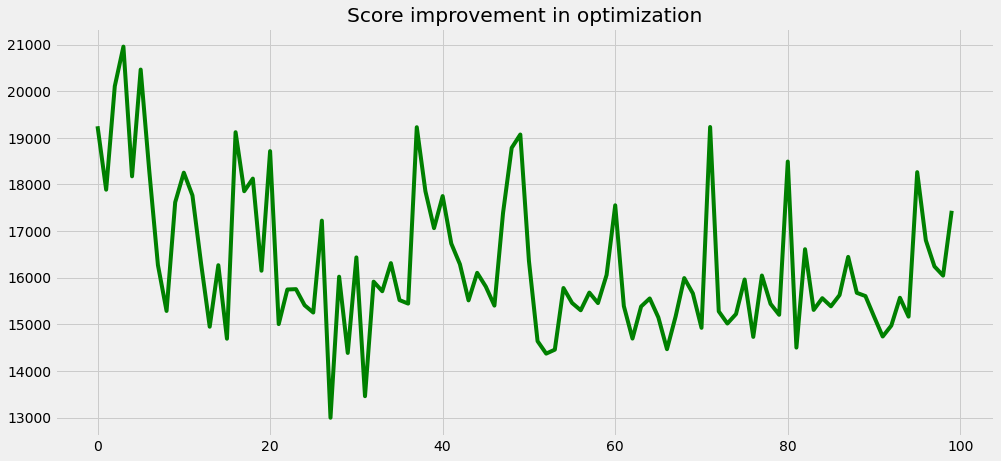

In [37]:
plt.figure(figsize=(15,7))
sns.lineplot(x=list(range(len(optuna_scores))),y=optuna_scores,color='green')
plt.title("Score improvement in optimization");

In [38]:
params = best.params
params['boosting_type'] = 'gbdt'
params['random_state'] = seed
params['objective'] = 'regression'
params['metric']= 'RMSE'
params['early_stopping_rounds'] = 100
params['num_boost_round'] = 100000
params

{'bagging_fraction': 0.9992710829788103,
 'bagging_freq': 8,
 'boosting_type': 'gbdt',
 'early_stopping_rounds': 100,
 'feature_fraction': 0.4616489585318717,
 'lambda_l1': 0.0001259404068828715,
 'lambda_l2': 2.4228946143770897e-07,
 'learning_rate': 0.21439500466986972,
 'max_bin': 366,
 'max_depth': 9,
 'metric': 'RMSE',
 'min_child_samples': 4,
 'min_child_weight': 4,
 'num_boost_round': 100000,
 'num_leaves': 952,
 'objective': 'regression',
 'random_state': 1000}

## Best Model after few experiments

In [39]:
best_param = {'bagging_fraction': 0.9539546363078697,
'bagging_freq': 2,
'boosting_type': 'gbdt',
'early_stopping_rounds': 100,
'feature_fraction': 0.42004879054723654,
'lambda_l1': 7.823697032797608e-08,
'lambda_l2': 1.5094951414534283e-05,
'learning_rate': 0.0277724473845362,
'max_bin': 521,
'max_depth': 9,
'metric': 'RMSE',
'min_child_samples': 4,
'min_child_weight': 5,
'num_boost_round': 100000,
'num_leaves': 671,
'objective': 'regression',
'random_state': 1000
}

In [40]:
rmse_scores, lgb_models = run_lgbm_nfolds(nfolds,best_param)

Fold: 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 939.979	valid_1's rmse: 13299.7
Early stopping, best iteration is:
[926]	training's rmse: 1122.41	valid_1's rmse: 13292.3
Fold: 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 878.009	valid_1's rmse: 16436.1
[2000]	training's rmse: 118.329	valid_1's rmse: 16300.1
[3000]	training's rmse: 27.4879	valid_1's rmse: 16277.9
[4000]	training's rmse: 8.1648	valid_1's rmse: 16272.8
[5000]	training's rmse: 2.61003	valid_1's rmse: 16271.4
[6000]	training's rmse: 0.755912	valid_1's rmse: 16271
[7000]	training's rmse: 0.227968	valid_1's rmse: 16270.9
[8000]	training's rmse: 0.0675834	valid_1's rmse: 16270.9
[9000]	training's rmse: 0.0225658	valid_1's rmse: 16270.9
[10000]	training's rmse: 0.00719422	valid_1's rmse: 16270.9
[11000]	training's rmse: 0.00212325	valid_1's rmse: 16270.9
[12000]	training's rmse: 0.000668658	valid_1's rmse: 16270.9
[13000]	training's rmse:

In [41]:
print("Best Model score after optimization is: ",np.mean(rmse_scores))

Best Model score after optimization is:  16142.930827424028


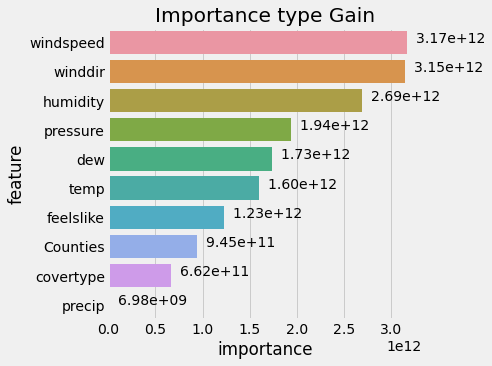

In [42]:
plot_feature_importance(lgb_models[0])

In [43]:
def make_prediction(x_test,lgb_models):
  return np.mean([model.predict(x_test) for model in lgb_models],axis=0)

In [44]:
predictions = make_prediction(x_valid,lgb_models)

## params

In [51]:
# {'bagging_fraction': 0.9539546363078697,
#  'bagging_freq': 2,
#  'boosting_type': 'gbdt',
#  'early_stopping_rounds': 100,
#  'feature_fraction': 0.42004879054723654,
#  'lambda_l1': 7.823697032797608e-08,
#  'lambda_l2': 1.5094951414534283e-05,
#  'learning_rate': 0.0277724473845362,
#  'max_bin': 521,
#  'max_depth': 9,
#  'metric': 'RMSE',
#  'min_child_samples': 4,
#  'min_child_weight': 5,
#  'num_boost_round': 10000,
#  'num_leaves': 671,
#  'objective': 'regression',
#  'random_state': 1000}
# rmse score:  16363.932056689471, 16142.93108868135

# {'bagging_fraction': 0.9676896410985087,
#  'bagging_freq': 1,
#  'boosting_type': 'gbdt',
#  'early_stopping_rounds': 100,
#  'feature_fraction': 0.8559864045430534,
#  'lambda_l1': 0.06835968159139877,
#  'lambda_l2': 1.0294805148676963e-08,
#  'learning_rate': 0.13967558432962945,
#  'max_bin': 894,
#  'max_depth': 10,
#  'metric': 'RMSE',
#  'min_child_samples': 63,
#  'min_child_weight': 7,
#  'num_boost_round': 100000,
#  'num_leaves': 787,
#  'objective': 'regression',
#  'random_state': 1000}

# {'bagging_fraction': 0.9676896410985087,
#  'bagging_freq': 1,
#  'boosting_type': 'gbdt',
#  'early_stopping_rounds': 100,
#  'feature_fraction': 0.8559864045430534,
#  'lambda_l1': 0.06835968159139877,
#  'lambda_l2': 1.0294805148676963e-08,
#  'learning_rate': 0.13967558432962945,
#  'max_bin': 894,
#  'max_depth': 10,
#  'metric': 'RMSE',
#  'min_child_samples': 63,
#  'min_child_weight': 7,
#  'num_boost_round': 100000,
#  'num_leaves': 787,
#  'objective': 'regression',
#  'random_state': 1000}

# {'bagging_fraction': 0.9467764338165396,
#  'bagging_freq': 2,
#  'boosting_type': 'gbdt',
#  'early_stopping_rounds': 100,
#  'feature_fraction': 0.4460601214617755,
#  'lambda_l1': 1.9180844963946806e-07,
#  'lambda_l2': 0.9796327369235562,
#  'learning_rate': 0.0834135733171516,
#  'max_bin': 511,
#  'max_depth': 9,
#  'metric': 'RMSE',
#  'min_child_samples': 38,
#  'min_child_weight': 11,
#  'num_boost_round': 100000,
#  'num_leaves': 819,
#  'objective': 'regression',
#  'random_state': 1000}

# {'bagging_fraction': 0.9208102909245581,
#  'bagging_freq': 3,
#  'boosting_type': 'gbdt',
#  'early_stopping_rounds': 100,
#  'feature_fraction': 0.401586288768529,
#  'lambda_l1': 5.106151665484112e-08,
#  'lambda_l2': 0.0008818950823319851,
#  'learning_rate': 0.26673619983038754,
#  'max_bin': 369,
#  'max_depth': 5,
#  'metric': 'RMSE',
#  'min_child_samples': 4,
#  'min_child_weight': 3,
#  'num_boost_round': 100000,
#  'num_leaves': 719,
#  'objective': 'regression',
#  'random_state': 1000}